In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline()
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
warnings.warn('this will not show')
pd.set_option('display.max_columns',None)



In [ ]:
df = pd.read_csv('amazon.csv')
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


In [ ]:
df = df.sort_values('wilson_lower_bound', ascending = False)
df.drop('Unnamed: 0', inplace = True, axis =1)
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,I have tested dozens of SDHC and micro-SDHC ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,NOTE: please read the last update (scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,"If your card gets hot enough to be painful, it...",09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,Sandisk announcement of the first 128GB micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [ ]:
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,I have tested dozens of SDHC and micro-SDHC ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,NOTE: please read the last update (scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,"If your card gets hot enough to be painful, it...",09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,Sandisk announcement of the first 128GB micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [ ]:
def missing_values_analysis(df):
  na_columns_ = [col for col in df.columns if df[col].isnull().sum()>0]
  n_miss = df[na_columns_].isnull().sum().sort_values(ascending = True)
  ratio_ = (df[na_columns_].isnull().sum()/df.shape[0]*100).sort_values(ascending=True)
  missing_df = pd.concat([n_miss,np.round(ratio_,2)],axis=1,keys=['Missing Values','Ratio'])
  missing_df = pd.DataFrame(missing_df)
  return missing_df

In [ ]:
def check_dataframe(df,  head=5, tail = 5):
  print("SHAPE".center(82,'~'))
  print('Rows: {}'.format(df.shape[0]))
  print('Columns: {}'.format(df.shape[1]))
  print('TYPES'.center(82,'~'))
  print(df.dtypes)
  print("".center(82,'~'))
  print(missing_values_analysis(df))
  print('DUPLICATED VALUES'.center(83,'~'))
  print(df.duplicated().sum())
  print('QUALITIES'.center(82,'~'))
  print(df.quantile([0,0.05,0.50,0.95,0.99,1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Missing Values  Ratio
reviewerName               1   0.02
reviewText                 1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUALITIES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00  0.05   0.50        0.95       0.99         1.00
overall 

In [ ]:
def check_class(dataframe):
  nunique_df = pd.DataFrame({'Variable':dataframe.columns,
                               'Classes':[dataframe[i].nunique()\
                                         for i in dataframe.columns ]})
  nunique_df = nunique_df.sort_values('Classes',ascending = False)
  nunique_df = nunique_df.reset_index(drop=True)
  return nunique_df
check_class(df)

,Variable,Classes
0,reviewText,4912
1,reviewerName,4594
2,reviewTime,690
3,day_diff,690
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


In [ ]:
constraints = ['#B34D22','#EBE00C','#1FEB0C','#0C92EB','#EB0CD5']
def categorical_variables_summary(df, column_name):
  fig = make_subplots(rows=1, cols=2,subplot_titles =('Countplot','Percentage'),
                      specs=[[{'types':'xy'},{'types':'domain'}]])
  fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                       x=[str(i) for i in df[column_name].value_counts().index],
                       text = df[column_name].value_counts().values.tolist(),
                       textfont = dict(size=14),
                       name=column_name,
                       textposition='auto',
                       showlegend=False,
                      marker = dict(color = constraints,line = dict(color = '#DBE6EC',width=1))),row=1,col=1)
  fig.add_trace(go.pie(labels = df[column_name].value_counts().keys(),values = df[column_name].value_counts().values,textfont=dict(size=18),position='auto',showlegend=False,name=column_name,marker=dict(colors=constraints)),row=1,col=2)
  fig.update_layout(Title={'text':column_name,
                            'y':0.9,
                            'x':0.5,
                            'xanchor':'center',
                            'yanchor':'top'},
                            template='plotly_white')
  iplot(fig)

In [ ]:
categorical_variables_summary(df,'overall')

ValueError: 
Invalid key specified in an element of the 'specs' argument to make_subplots: 'types'
    Valid keys include: ['type', 'secondary_y', 'colspan', 'rowspan', 'l', 'r', 'b', 't']

KeyError: 5

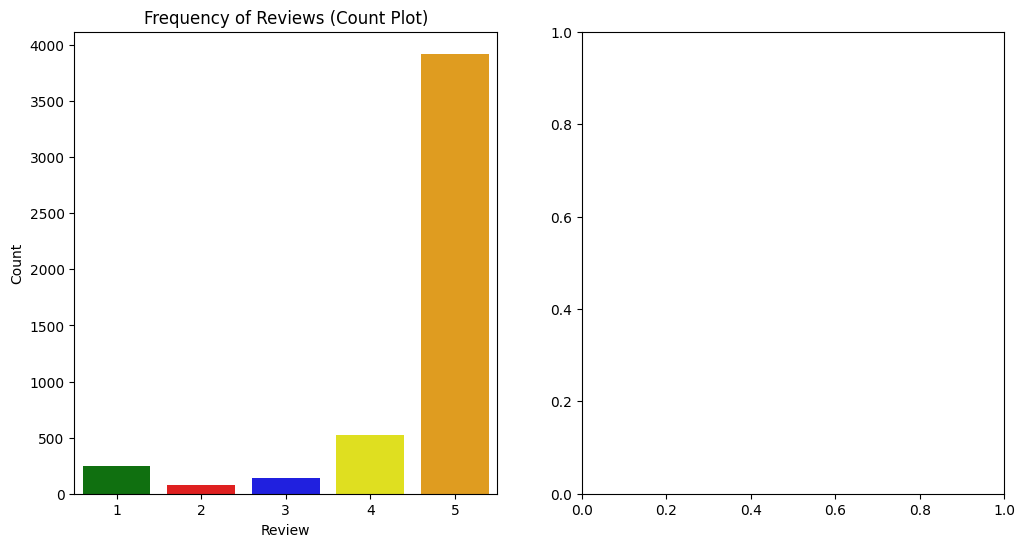

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette
colors = {'1': 'green', '5': 'red', '2': 'blue','3':'yellow','4':'orange'}

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot count plot
sns.countplot(x='overall', data=df, palette=colors.values(), ax=axs[0])
axs[0].set_title('Frequency of Reviews (Count Plot)')
axs[0].set_xlabel('Review')
axs[0].set_ylabel('Count')

# Plot pie chart
review_counts = df['overall'].value_counts()
axs[1].pie(review_counts, labels=review_counts.index, autopct='%1.1f%%', colors=[colors[val] for val in review_counts.index])
axs[1].set_title('Frequency of Reviews (Pie Chart)')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


([<matplotlib.patches.Wedge at 0x7fb4a0351c60>,
 [Text(-0.8857677968469639, 0.6522387676831818, '5'),
  Text(0.6553486246281577, -0.8834693996953048, '4'),
  Text(0.9953396829526331, -0.468293621075231, '1'),
  Text(1.0795694357025911, -0.2110209314186374, '3'),
  Text(1.0985621918556094, -0.05622375499198917, '2')],
 [Text(-0.48314607100743484, 0.3557666005544628, '79.80%'),
  Text(0.3574628861608133, -0.48189239983380255, '10.72%'),
  Text(0.5429125543377998, -0.2554328842228532, '4.96%'),
  Text(0.5888560558377769, -0.11510232622834765, '2.89%'),
  Text(0.5992157410121506, -0.03066750272290318, '1.63%')])

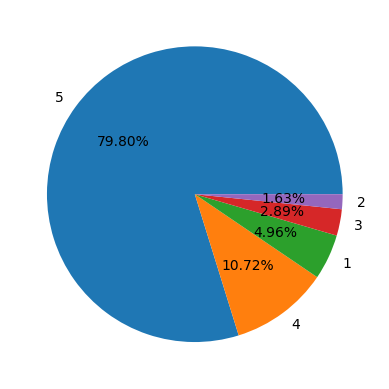

In [ ]:
country_names = df.overall.value_counts().index
country_val = df.overall.value_counts().values
plt.pie(country_val,labels=country_names,autopct='%1.2f%%')

In [ ]:
df.reviewText.head()

2031    [[ UPDATE - 6/19/2014 ]]So my lovely wife boug...
3449    I have tested dozens of SDHC and micro-SDHC ca...
4212    NOTE:  please read the last update (scroll to ...
317     If your card gets hot enough to be painful, it...
4672    Sandisk announcement of the first 128GB micro ...
Name: reviewText, dtype: object

In [ ]:
review_example = df.reviewText[2031]
review_example

'[[ UPDATE - 6/19/2014 ]]So my lovely wife bought me a Samsung Galaxy Tab 4 for Father\'s Day and I\'ve been loving it ever since.  Just as other with Samsung products, the Galaxy Tab 4 has the ability to add a microSD card to expand the memory on the device.  Since it\'s been over a year, I decided to do some more research to see if SanDisk offered anything new.  As of 6/19/2014, their product lineup for microSD cards from worst to best (performance-wise) are the as follows:SanDiskSanDisk UltraSanDisk Ultra PLUSSanDisk ExtremeSanDisk Extreme PLUSSanDisk Extreme PRONow, the difference between all of these cards are simply the speed in which you can read/write data to the card.  Yes, the published rating of most all these cards (except the SanDisk regular) are Class 10/UHS-I but that\'s just a rating... Actual real world performance does get better with each model, but with faster cards come more expensive prices.  Since Amazon doesn\'t carry the Ultra PLUS model of microSD card, I had 

In [ ]:
review_example  =re.sub('[^a-zA-Z]','',review_example)
review_example

'UPDATESomylovelywifeboughtmeaSamsungGalaxyTabforFathersDayandIvebeenlovingiteversinceJustasotherwithSamsungproductstheGalaxyTabhastheabilitytoaddamicroSDcardtoexpandthememoryonthedeviceSinceitsbeenoverayearIdecidedtodosomemoreresearchtoseeifSanDiskofferedanythingnewAsoftheirproductlineupformicroSDcardsfromworsttobestperformancewisearetheasfollowsSanDiskSanDiskUltraSanDiskUltraPLUSSanDiskExtremeSanDiskExtremePLUSSanDiskExtremePRONowthedifferencebetweenallofthesecardsaresimplythespeedinwhichyoucanreadwritedatatothecardYesthepublishedratingofmostallthesecardsexcepttheSanDiskregularareClassUHSIbutthatsjustaratingActualrealworldperformancedoesgetbetterwitheachmodelbutwithfastercardscomemoreexpensivepricesSinceAmazondoesntcarrytheUltraPLUSmodelofmicroSDcardIhadtododirectcomparisonsbetweentheSanDiskUltraExtremeandExtremePLUSAsmentionedinmyearlierreviewIpurchasedtheSanDiskUltraformyGalaxySMyquestionwasdidIwanttopayovermoreforacardthatisfasterthantheoneIalreadyownedOrIcouldpayalmostdoubletoget

In [ ]:
review_example = review_example.lower().split()
review_example

['updatesomylovelywifeboughtmeasamsunggalaxytabforfathersdayandivebeenlovingiteversincejustasotherwithsamsungproductsthegalaxytabhastheabilitytoaddamicrosdcardtoexpandthememoryonthedevicesinceitsbeenoverayearidecidedtodosomemoreresearchtoseeifsandiskofferedanythingnewasoftheirproductlineupformicrosdcardsfromworsttobestperformancewisearetheasfollowssandisksandiskultrasandiskultraplussandiskextremesandiskextremeplussandiskextremepronowthedifferencebetweenallofthesecardsaresimplythespeedinwhichyoucanreadwritedatatothecardyesthepublishedratingofmostallthesecardsexceptthesandiskregularareclassuhsibutthatsjustaratingactualrealworldperformancedoesgetbetterwitheachmodelbutwithfastercardscomemoreexpensivepricessinceamazondoesntcarrytheultraplusmodelofmicrosdcardihadtododirectcomparisonsbetweenthesandiskultraextremeandextremeplusasmentionedinmyearlierreviewipurchasedthesandiskultraformygalaxysmyquestionwasdidiwanttopayovermoreforacardthatisfasterthantheoneialreadyownedoricouldpayalmostdoubletoge

In [ ]:
rt = lambda x:re.sub('[^a-zA-Z]',' ',str(x))
df['reviewText'] = df['reviewText'].map(rt)
df['reviewText'] = df['reviewText'].str.lower()
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [ ]:
! pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
df[['polarity','subjectivity']] = df['reviewText'].apply(lambda text:pd.Series(TextBlob(text).sentiment))
for index,row in df['reviewText'].iteritems():
  score = SentimentIntensityAnalyzer().polarity_scores(row)
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  if neg>pos:
    df.loc[index,'sentiment']='Negative'
  elif pos>neg:
    df.loc[index,'sentiment']='Positive'
  else:
    df.loc[index,'sentiment']='Neutral'

In [ ]:
df[df['sentiment']=='Positive'].sort_values('wilson_lower_bound',
                                            ascending = False).head(5)

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,polarity,subjectivity,sentiment
2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544,0.163859,0.562259,Positive
3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519,0.103870,0.516435,Positive
4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139,0.212251,0.505394,Positive
317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577,0.143519,0.494207,Positive
4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109,0.172332,0.511282,Positive


In [ ]:
categorical_variables_summary(df,'sentiment')

ValueError: 
Invalid key specified in an element of the 'specs' argument to make_subplots: 'types'
    Valid keys include: ['type', 'secondary_y', 'colspan', 'rowspan', 'l', 'r', 'b', 't']

([<matplotlib.patches.Wedge at 0x7fb49f4fe530>,
 [Text(-0.9160057397383922, 0.609043089416768, 'Positive'),
  Text(0.795871999766985, -0.7593337605999753, 'Negative'),
  Text(1.0831729769666218, -0.19166716455685923, 'Neutral')],
 [Text(-0.4996394944027593, 0.3322053215000553, '81.32%'),
  Text(0.43411199987290083, -0.4141820512363501, '13.10%'),
  Text(0.5908216237999755, -0.1045457261219232, '5.57%')])

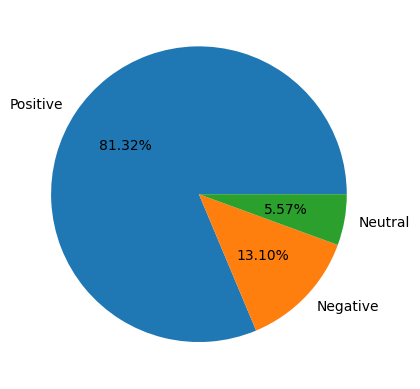

In [ ]:
country_names = df.sentiment.value_counts().index
country_val = df.sentiment.value_counts().values
plt.pie(country_val,labels=country_names,autopct='%1.2f%%')

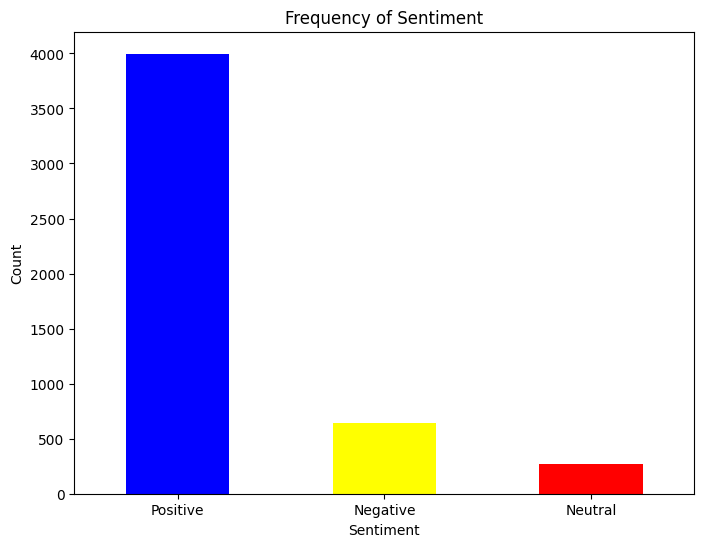

In [ ]:
review_counts = df['sentiment'].value_counts()
# Create a bar plot
plt.figure(figsize=(8, 6))
review_counts.plot(kind='bar', color=['blue', 'yellow', 'red'])  # Assigning colors for each category
plt.title('Frequency of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.show()

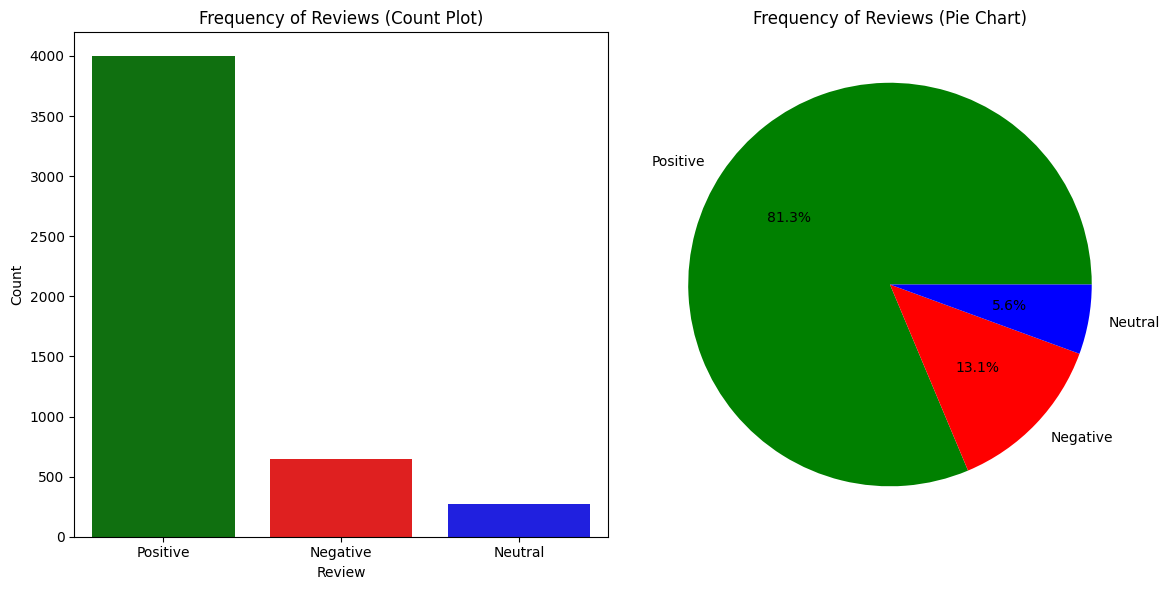

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot count plot
sns.countplot(x='sentiment', data=df, palette=colors.values(), ax=axs[0])
axs[0].set_title('Frequency of Reviews (Count Plot)')
axs[0].set_xlabel('Review')
axs[0].set_ylabel('Count')

# Plot pie chart
review_counts = df['sentiment'].value_counts()
axs[1].pie(review_counts, labels=review_counts.index, autopct='%1.1f%%', colors=[colors[val] for val in review_counts.index])
axs[1].set_title('Frequency of Reviews (Pie Chart)')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd

def sentiment_analysis(text):
    sentiment = TextBlob(text).sentiment
    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity

    score = SentimentIntensityAnalyzer().polarity_scores(text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']

    if neg > pos:
        sentiment = 'Negative'
    elif pos > neg:
        sentiment = 'Positive'
    else:
        sentiment = 'Neutral'

    return {'Polarity': polarity, 'Subjectivity': subjectivity, 'VADER Sentiment': sentiment}

# Test the function
text = "I was so excited to try this product out, but unfortunately, my experience was a complete letdown. The product is not only low quality, but also doesn't work as expected."
print(sentiment_analysis(text))


{'Polarity': -0.020833333333333332, 'Subjectivity': 0.6416666666666666, 'VADER Sentiment': 'Positive'}
